In [13]:
import os
import json
import requests
from PIL import Image
import random
import re, os, json
from typing import Any, List, Mapping, Optional

import langchain
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM


def extract_path_and_convert_token(input_data, img_dir=''):
    img_path_pattern = re.compile(r'<img_path>(.*?)<img_path>')
    img_paths = [os.path.join(img_dir, path) for path in img_path_pattern.findall(input_data)]
    
    input_data_converted = img_path_pattern.sub('<image>', input_data)
    return input_data_converted, img_paths


def get_prompt_instruction(instruction):
    if '### Assistant:' not in instruction:
        return f'### Human: {instruction}\n### Assistant: '
    else:
        return f'### Human: {instruction}'


class CleverFlamingo(LLM):
    
    url: str

    @property
    def _llm_type(self) -> str:
        return "custom"

    def clever_flamingo(
            self, 
            prompt,
            max_new_token=2048, 
            num_beams=3, 
            temperature=1.0,
            top_k=20, 
            top_p=0.9, 
            do_sample=False, 
            length_penalty=1.0, 
            no_repeat_ngram_size=3,
            ):
        prompt, imgpaths = extract_path_and_convert_token(prompt)
        prompt = get_prompt_instruction(prompt)

        content_lst = {
            'prompt': prompt,
            'imgpaths': imgpaths,
            'args':{
                'max_new_token':max_new_token,
                'num_beams':num_beams,
                'temperature':temperature,
                'top_k':top_k,
                'top_p':top_p,
                'do_sample':do_sample,
                'length_penalty':length_penalty,
                'no_repeat_ngram_size':no_repeat_ngram_size,
            }
        }
        d = {"content_lst": content_lst,'typ': 'None'}
        d = json.dumps(d).encode('utf8')
        try:
            r = requests.post(self.url, data=d, timeout=1800)
            return json.loads(r.text)['result']['response'][0]
        except requests.exceptions.ReadTimeout:
            return '[Clever Flamingo]: Sorry, timeout (1800) due to server overload, please try again.' 


    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
    ) -> str:
        # if stop is not None:
        #     raise ValueError("stop kwargs are not permitted.")
        
        response = self.clever_flamingo(prompt)
        return response

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        """Get the identifying parameters."""
        return {"url": self.url}
    
llm = CleverFlamingo(url='http://0.0.0.0:2014/clever_flamingo')
print(llm)

CleverFlamingo
Params: {'url': 'http://0.0.0.0:2014/clever_flamingo'}


### Caption Verification

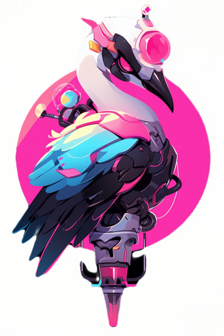



> Entering new LLMChain chain...
Prompt after formatting:
Given a caption related to an image, decompose it into several independent, atomized, complete, yet succinct sentences of image captions. Each captions should be as simple as possible, and cannot be divided further. They corresponds to different aspects of the original sentence. 
Please make sure that all of the key information is comprehensively retained. However, do not add any additional information that is not present in the original caption. 
The caption to process is: "This image contains a cool dog in pink color, seems like an icon instead of a real image"
### Assistant: The followings are some image captions decomposed from the original one:
1.

> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
<img_path>/cpfs/user/chendelong/open_flamingo_v2/docs/flamingo.png<img_path>Convert this sentence about the image 'There is a dog in the image.' into a complete caption, but keep it as simple as possi

In [11]:
from chains import CaptionVerificationChain

caption = 'This image contains a cool dog in pink color, seems like an icon instead of a real image'
path_to_codebase = '/cpfs/user/chendelong/open_flamingo_v2'
img_path = f'{path_to_codebase}/docs/flamingo.png'
Image.open(img_path).resize((224,336)).show()

chain = CaptionVerificationChain.from_llm(llm=llm, verbose=True)
revised_caption = chain(inputs={"caption": caption, "img_path": img_path})

import pprint
pprint.pprint(revised_caption, width=256)